In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error as mean_squared_error
import math

In [16]:
# df = pd.read_stata("../data/variables_productos_primarios.dta",index_col="fecha")
# df = df.drop(["mes","anio"],axis=1)
# df["pp"] = df.pp / 1_000_000
# df.index = df.index.to_period('M')

In [17]:
# df = pd.read_excel("../data/data.xlsx",index_col=0)[:"11-2022"]
df = pd.read_excel("../data/data.xlsx",index_col=0)
df

,pp,pi,gap,er_cp,pre
2005-01-31,508.020737,86.866026,1.154717,827.759645,1423.333333
2005-02-28,500.539941,87.907449,1.160477,805.766198,969.666667
2005-03-31,656.181802,86.226525,1.170061,794.915295,1730.000000
2005-04-30,939.064907,87.964450,1.149008,797.011580,620.000000
2005-05-31,1028.823820,89.117152,1.121609,789.385468,54.666667
...,...,...,...,...,...
2023-05-31,1327.915111,200.236721,2.056724,329.136717,1063.333333
2023-06-30,1273.885921,203.825746,2.034506,334.335871,23.333333
2023-07-31,1419.644081,189.738936,2.008257,336.234909,320.000000
2023-08-31,1464.106039,178.606070,2.136985,360.724410,35.000000


In [18]:
x_list = [
          "pi",
          "pre",
          "er_cp",
          "gap"
          ]
meses_testeo = 24
meses_prediccion = 6
train = df[:-meses_testeo].copy()
test = df.copy()

In [19]:
y_train = train["pp"]
y_test = test["pp"]
X_train =train[x_list]
X_test = test[x_list]

MODEL_ORDERS = {
    'pp': {'order':(8,0,3), 'seasonal_order':(0,1,1,12)},
    'er_cp': {'order':(1,0,4), 'seasonal_order':None},
    'pi': {'order':(4,0,5), 'seasonal_order':(0,1,1,12)},
    'pre': {'order':(8,0,9), 'seasonal_order':(0,0,0,12)},
    'gap': {'order':(1,1,9), 'seasonal_order':None}
                }

MODEL_ORDERS = {
    'pp': {'order':(1,0,0), 'seasonal_order':(1,0,1,12)},
    'er_cp': {'order':(7,1,2), 'seasonal_order':None},
    'pi': {'order':(9,1,9), 'seasonal_order':(1,1,0,12)},
    'pre': {'order':(7,0,2), 'seasonal_order':(1,1,0,12)},
    'gap': {'order':(5,0,3), 'seasonal_order':None}
                }

1. Estimar las exogenas n meses en train  (X_new_train)
2. Estimar las exogenas n meses en test (X_new_test)
3. Estimar la endógena n meses en train (usando X_new_train) 
4. Estimar la endógena n meses en test (usando X_new_test)

In [20]:
train_model_er_cp = SARIMAX(train[["er_cp"]],order = MODEL_ORDERS['er_cp']['order'], seasonal_order=MODEL_ORDERS['er_cp']['seasonal_order'])
train_model_pi = SARIMAX(train[["pi"]], order=MODEL_ORDERS['pi']['order'], seasonal_order=MODEL_ORDERS['pi']['seasonal_order'])
train_model_pre = SARIMAX(np.log(train[["pre"]]+1), order=MODEL_ORDERS['pre']['order'], seasonal_order=MODEL_ORDERS['pre']['seasonal_order'])
train_model_gap = SARIMAX(train[["gap"]], order=MODEL_ORDERS['gap']['order'], seasonal_order=MODEL_ORDERS['gap']['seasonal_order'])

test_model_er_cp = SARIMAX(test[["er_cp"]],order = MODEL_ORDERS['er_cp']['order'], seasonal_order=MODEL_ORDERS['er_cp']['seasonal_order'])
test_model_pi = SARIMAX(test[["pi"]], order=MODEL_ORDERS['pi']['order'], seasonal_order=MODEL_ORDERS['pi']['seasonal_order'])
test_model_pre = SARIMAX(np.log(test[["pre"]]+1), order=MODEL_ORDERS['pre']['order'], seasonal_order=MODEL_ORDERS['pre']['seasonal_order'])
test_model_gap = SARIMAX(test[["gap"]], order=MODEL_ORDERS['gap']['order'], seasonal_order=MODEL_ORDERS['gap']['seasonal_order'])

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\stat

In [21]:
modelos_exogenas = {train_model_pi:"pi", train_model_pre:"pre", train_model_er_cp:"er_cp", train_model_gap:"gap"}
X_train =train[x_list]

for modelo in modelos_exogenas:
    variable = modelos_exogenas[modelo]
    order = MODEL_ORDERS[variable]["order"]
    seasonal_order = MODEL_ORDERS[variable]["seasonal_order"]
    seasonal_order = "" if not seasonal_order else seasonal_order
    fitted = modelo.fit()
    forecast = fitted.forecast(meses_testeo)
    forecast = pd.concat([fitted.fittedvalues, forecast])
    if modelo == train_model_pre:
        forecast = np.exp(forecast) #Transformación de inversión
    obs_pred_df = pd.DataFrame({"observado":test[variable],
                                "prediccion": forecast})
    RMSE = round(math.sqrt(mean_squared_error(obs_pred_df["observado"], obs_pred_df["prediccion"])), 2)
    plot_predicc_obs_exog = go.Figure()
    # plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_df.index, y = obs_pred_df["observado"], name = "Observación"))
    plot_predicc_obs_exog.add_trace(go.Scatter(x=df.index, y = df[variable], name = "Observación"))
    plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_df.index, y = obs_pred_df["prediccion"], name = "Predicción"))
    plot_predicc_obs_exog.add_vline(x = obs_pred_df.index[-meses_testeo], line_width=3, line_dash="dash", line_color="green")
    plot_predicc_obs_exog.update_layout(template = None, title_text =f"Testeo modelo para \"{variable}\"<br><sup>{order}{seasonal_order}. RMSE: {RMSE}",
    font_family = "georgia")
    plot_predicc_obs_exog.write_image(f"../output/testeo_exog_sarimax/testeo_exog_sarimax_{variable}.pdf")
    plot_predicc_obs_exog.show()

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [22]:
X_new_train = pd.DataFrame()
for modelo in modelos_exogenas:
    fitted = modelo.fit(disp=False)
    forecast = fitted.forecast(meses_testeo)
    # forecast = pd.concat([fitted.fittedvalues, forecast]) 
    if modelo == train_model_pre:
        forecast = np.exp(forecast)
    X_new_train[modelos_exogenas[modelo]] = forecast
X_new_train = X_new_train[x_list]

X_new_test = pd.DataFrame()
for modelo in modelos_exogenas:
    fitted = modelo.fit(disp=False)
    forecast = fitted.forecast(meses_prediccion)
    # forecast = pd.concat([fitted.fittedvalues, forecast]) 
    if modelo == test_model_pre:
        forecast = np.exp(forecast)
    X_new_test[modelos_exogenas[modelo]] = forecast
X_new_test = X_new_test[x_list]

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\stats

In [23]:
train_model_pp = SARIMAX(y_train, order=MODEL_ORDERS['pp']['order'], seasonal_order=MODEL_ORDERS['pp']['seasonal_order'],
                         exog=X_train)
test_model_pp = SARIMAX(y_test, order=MODEL_ORDERS['pp']['order'], seasonal_order=MODEL_ORDERS['pp']['seasonal_order'],
                        exog=X_test)

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



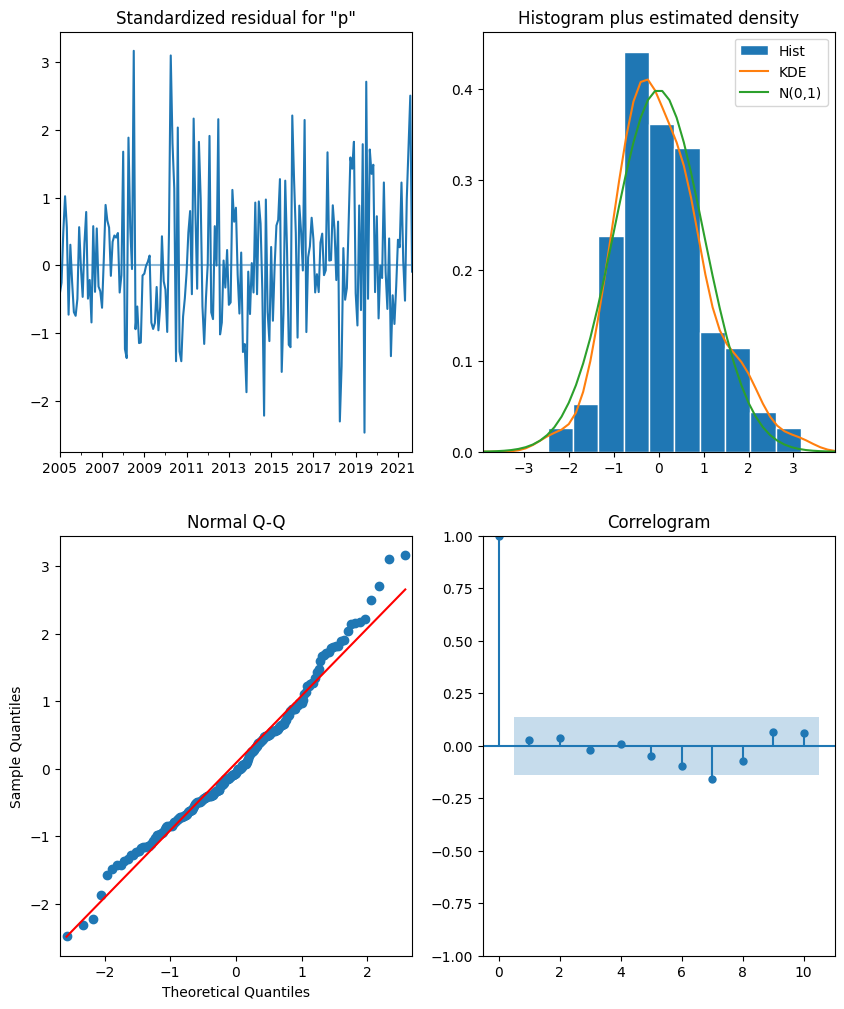

In [24]:
train_model_pp.fit().plot_diagnostics(figsize=(10, 12))
plt.show()

In [25]:
fitted = train_model_pp.fit(disp=False)
order_main = MODEL_ORDERS["pp"]["order"]
seasonal_order_main = MODEL_ORDERS["pp"]["seasonal_order"]
forecast_train = fitted.forecast(meses_testeo, exog = X_new_train)
forecast_train = pd.concat([fitted.fittedvalues, forecast_train])
obs_pred_df = pd.DataFrame({"observado":y_test,
                            "prediccion": forecast_train})
RMSE = round(math.sqrt(mean_squared_error(obs_pred_df["observado"], obs_pred_df["prediccion"])), 2)
plot_predicc_obs_exog = go.Figure()
plot_predicc_obs_exog.add_trace(go.Scatter(x=y_test.index, y = y_test, name = "Observación"))
plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_df.index, y = obs_pred_df["prediccion"], name = "Predicción"))
plot_predicc_obs_exog.add_vline(x = obs_pred_df.index[-meses_testeo], line_width=3, line_dash="dash", line_color="green")
plot_predicc_obs_exog.update_layout(template = None, title_text =f"Testeo del modelo para \"{'pp'}\"<br><sup>{order_main}{seasonal_order_main}. RMSE: {RMSE}",
font_family = "georgia")
plot_predicc_obs_exog.write_image("../output/testeo_exog_sarimax/testeo_endog_sarimax_pp.pdf")
plot_predicc_obs_exog.show()

In [26]:
fitted = test_model_pp.fit(disp=False)
forecast_test = fitted.forecast(meses_prediccion, exog = X_new_test)
forecast_test = pd.concat([fitted.fittedvalues, forecast_test])
obs_pred_test = pd.DataFrame({"observado":y_test,
                            "prediccion": forecast_test})
plot_predicc_obs_exog = go.Figure()
plot_predicc_obs_exog.add_trace(go.Scatter(x=y_test.index, y = y_test, name = "Observación"))
plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_test.index, y = obs_pred_test["prediccion"], name = "Predicción"))
plot_predicc_obs_exog.add_vline(x = obs_pred_test.index[-meses_prediccion], line_width=3, line_dash="dash", line_color="green")
plot_predicc_obs_exog.update_layout(template = None, title_text =f"Predicción a 6 meses usando modelo SARIMAX \"{'pp'}\"<br><sup>Modelo: {order_main}{seasonal_order_main}",
font_family = "georgia")
plot_predicc_obs_exog.write_image("../output/Prediccion_sarimax_plot.pdf")
plot_predicc_obs_exog.show()

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

